In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [5]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Downloads/Plantvillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 4 classes.


In [11]:
class_names = dataset.class_names
class_names

['.ipynb_checkpoints',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [12]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[2 2 2 1 1 1 1 1 2 2 2 2 1 2 1 2 2 2 1 2 1 2 1 1 2 1 1 2 2 3 1 1]


In [13]:
#Visualize some of the images from our dataset

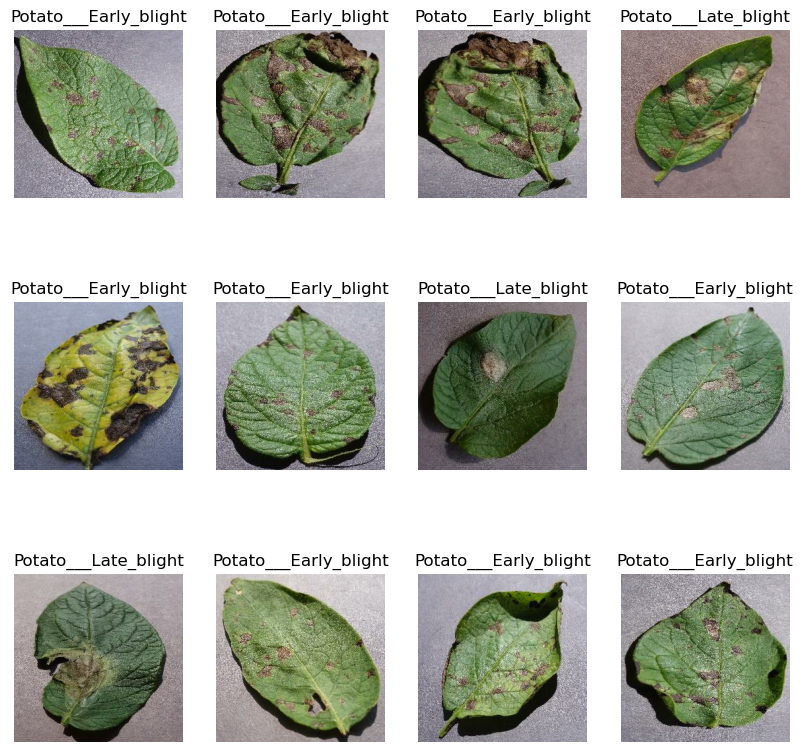

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [15]:
len(dataset)

68

In [16]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [17]:
train_ds = dataset.take(54)
len(train_ds)

54

In [18]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [19]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [20]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [21]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
len(train_ds)

54

In [25]:
len(val_ds)

6

In [26]:
len(test_ds)

8

In [27]:
#Cache, Shuffle, and Prefetch the Dataset

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [30]:
#Data Augmentation
#Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [31]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [32]:
#Applying Data Augmentation to Train Dataset

In [33]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [34]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [36]:
#Compiling the Model

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Early_blight


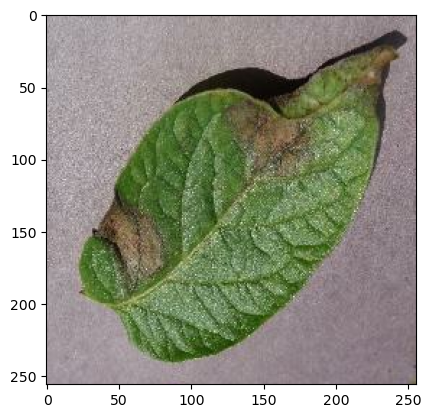

In [47]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [48]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 86ms/step


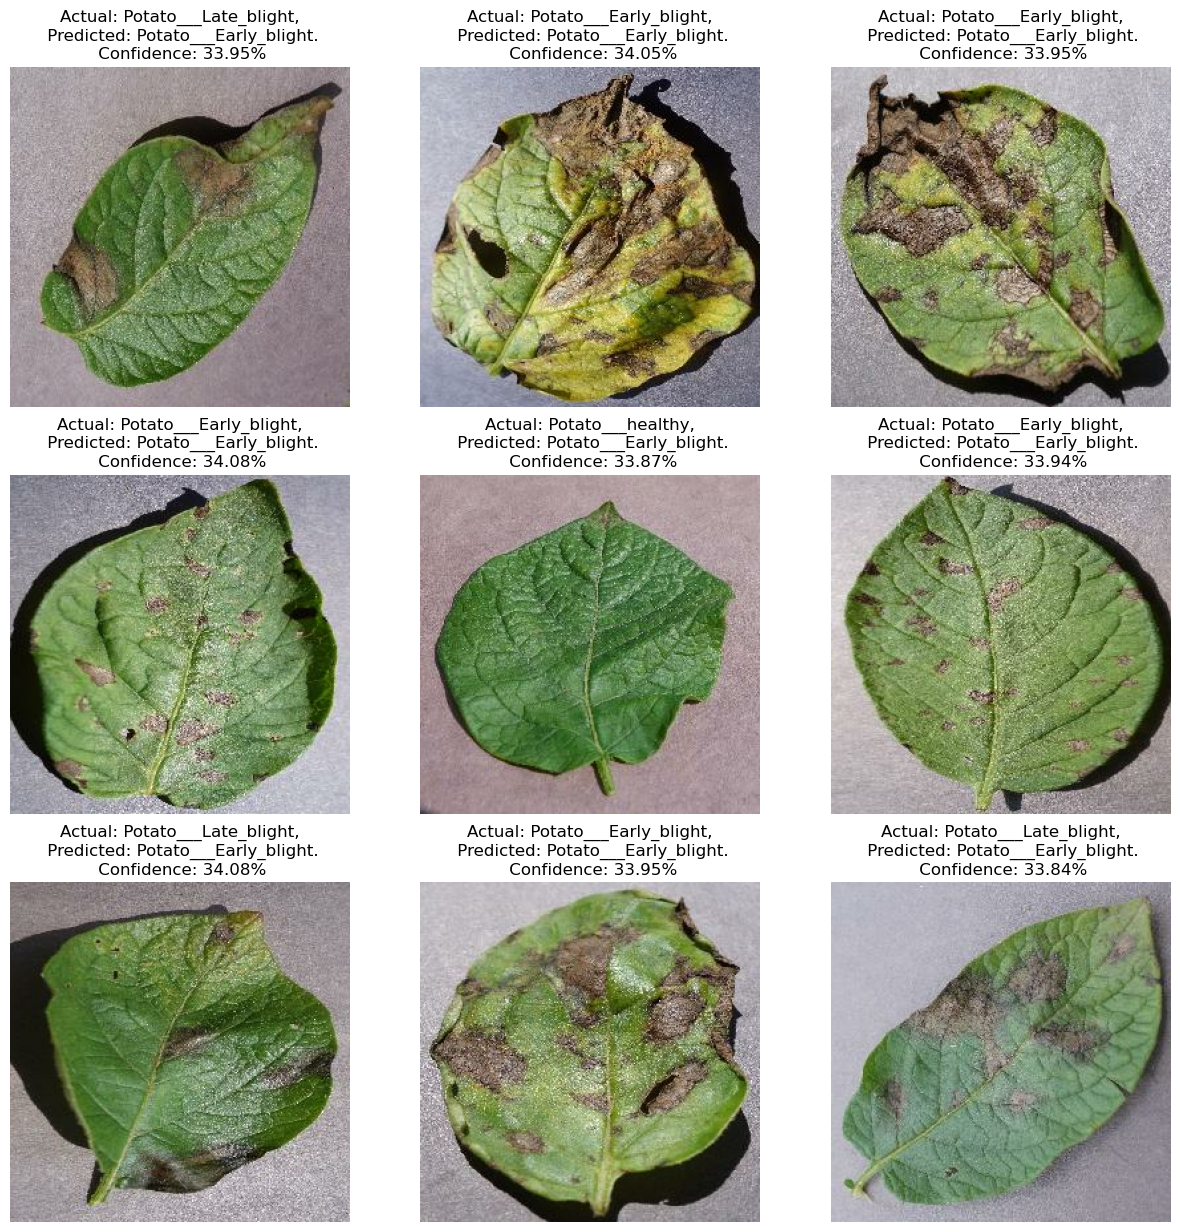

In [49]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")